In [ ]:
import torch
from torch import jit, Tensor
from aimnet.data import SizeGroupedDataset
from aimnet.config import build_module, load_yaml
from aimnet.modules import Forces
import yaml
import math
import numpy as np
from torch.optim.lr_scheduler import StepLR


In [2]:
torch.__version__

# pip3 install torch torchvision torchaudio


'2.2.0+cu121'

In [3]:
torch.cuda.is_available()

True

In [ ]:
##CORRECTION2, AIMNET2
# Define the sampler, in this case, a RandomSampler
# sampler = RandomSampler(train_ds)

ev2kcalmol = 23.0605


def loss_function(pred, true, q_weight, e_weight, f_weight):

    q_loss = charges_loss(pred['charges'], true['charges'], pred['_natom'])
    e_loss = energy_loss(pred['energy'], true['energy'], pred['_natom'])
    f_loss = forces_loss(pred['forces'], true['forces'], pred['_natom'])

    total_loss = q_weight*q_loss + e_weight*e_loss + f_weight*f_loss

    return total_loss

@jit.script
def charges_loss(pred: Tensor, true: Tensor, _natom: Tensor) -> Tensor:
    diff = pred - true
    loss = diff.pow(2).mean(-1)
    if _natom.numel() > 1:
        loss = loss * pred.shape[1] / _natom
    return loss

@jit.script
def energy_loss(pred: Tensor, true: Tensor, _natom: Tensor) -> Tensor:
    loss = (pred - true).pow(2) / _natom.sqrt()
    return loss

@jit.script
def forces_loss(pred: Tensor, true: Tensor, _natom: Tensor) -> Tensor:
    diff = pred - true
    loss = diff.pow(2).flatten(-2, -1).mean(-1)
    if _natom.numel() > 1:
        loss = loss * pred.shape[1] / _natom
    return loss


if __name__ == '__main__':

    ''' DEFINE CONSTANTS AND PARAMETERS '''
    train_loss_list = [] #TOTAL
    val_loss_list = [] #TOTAL
    
    RMSE_Charge=[]
    RMSE_Energy=[]
    RMSE_Force=[]
    TOTAL_RMSE=[]
    TOTAL_VAL_RMSE=[]
    
    Val_RMSE_Charge=[]
    Val_RMSE_Energy=[]
    Val_RMSE_Force=[]
    TOTAL_Val_RMSE=[]
    
    # BATCH_SIZE = 256
    BATCH_SIZE = 32
    EPOCHS = 3
    # MINIBATCH = 10
    # LR = 1e-4
    
    LR=1e-3
    # VALID_EVERY_N = 1
    q_weight = 0.05
    f_weight = 0.15
    e_weight = 0.80

    ''' CREATE MODEL FROM MODEL.YML FILE '''
    model = build_module('aimnet/models/aimnet2.yaml')
    model = Forces(model)
    model = torch.jit.script(model)

    ''' IF CUDA IS AVAILABLE, MOVE MODEL TO GPU '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # print(model)

    ''' CREATE TRAINING AND VALIDATION DATASETS '''
    train_ds = SizeGroupedDataset('train.h5')
    valid_ds = SizeGroupedDataset('valid.h5')

    
    ''' READ AND APPLY SELF ATOMIC ENERGY SHIFT '''
    sae = yaml.load(open('/mnt/c/Users/user/Desktop/DACON/I_WANT_TO_LEARN_AIMNET-main/train.sae').read(), Loader=yaml.SafeLoader)
    train_ds.apply_peratom_shift('energy', 'energy', sap_dict=sae)
    valid_ds.apply_peratom_shift('energy', 'energy', sap_dict=sae)
    
    
    
    train_sampler = SizeGroupedSampler(
    ds=train_ds,           
    batch_size=BATCH_SIZE,  
    batch_mode='molecules', 
    shuffle=True,           
    batches_per_epoch=-1    
    )

    valid_sampler = SizeGroupedSampler(
    ds=valid_ds,          
    batch_size=BATCH_SIZE, 
    batch_mode='molecules', 
    shuffle=False,          
    batches_per_epoch=-1    
    )


    
    ''' CREATE DATA LOADERS '''
    
    train_loader = train_ds.get_loader(x = ['coord', 'numbers', 'charge'], y = ['charges','energy','forces'], sampler=train_sampler)
    valid_loader = valid_ds.get_loader(x = ['coord', 'numbers', 'charge'], y = ['charges','energy','forces'], sampler=valid_sampler)

    
    
    # total_step=len(train_loader) ##ILKWON
    ''' SET UP OPTIMIZER '''
    optimizer = torch.optim.Adam(model.parameters(), lr=LR) 
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
    
    ''' TRAINING LOOP '''
    
    for EPOCH in range(EPOCHS):
        
        model.train()
        
        num_of_batch=0
        temp_train_loss=[]
        val_len=0
        temp_valid_loss=[]
        
        #Train
        squared_error_charges=[]
        squared_error_energy=[]
        squared_error_forces=[]
        
        #Multiplier
        multiplier=0
        val_multiplier=0
        
        
        multipler_f=0
        val_multiplier_f=0
        # summation=0
        # val_summation=0
        
        #Val
        val_squared_error_charges=[]
        val_squared_error_energy=[]
        val_squared_error_forces=[]
        
        # batch_train_loss=[]
        # batch_val_loss=[]
        
        for idx, (batch_data, batch_labels) in enumerate(train_loader): # iterate through all batches
            
            batch_train_loss=[]
            
            ''' ZERO GRADIENTS '''
            optimizer.zero_grad() 
        
            ''' CREATE INPUT DICTIONARY '''
            _in = dict(coord=batch_data['coord'].to(device), 
                    numbers=batch_data['numbers'].to(device), 
                    charge=batch_data['charge'].to(device))
        
            ''' FORWARD PASS ''' 
            _out = model(_in)
            
            num_of_batch += len(_out['energy'])
            # multiplier+=_out["_natom"].item()
            multiplier += np.prod(list(_out['charges'].size() ) )
            multipler_f += np.prod(list(_out['forces'].size() ) )
            # summation+=(len(_out['energy']))*(_out["_natom"].item())
            
            ''' MOVE LABELS TO GPU ''' 
            
            batch_labels = {key: batch_labels[key].to(device) for key in batch_labels}
            
            # for key in batch_labels:  #Customize
            #     batch_labels[key] = batch_labels[key].to(device)
            
            ''' CALCULATE LOSS '''
            loss = loss_function(_out, batch_labels, q_weight, e_weight, f_weight)
            
            # batch_train_loss
            batch_train_loss.extend([x.item() for x in loss])
            # print(len(batch_train_loss),"JUST FOR CHECK FOR THE BATCH_SIZE")
            
            temp_train_loss.append(sum(batch_train_loss) )
            
            
            #CALCULATE THE SQUARED ERRORS FOR TRAINING SET
            
            squared_error_charges.append( (((_out['charges'] - batch_labels['charges'])) ** 2).sum().item() )
            # print(len(batch_labels['charges']),squared_error_charges)
            squared_error_energy.append( (((_out['energy'] - batch_labels['energy']) * ev2kcalmol) ** 2).sum().item() )
            # conversion_factor = 23.06
            
            squared_diff = ( ( (_out['forces'] - batch_labels['forces']) * ev2kcalmol ) ** 2 ).sum().item()
            squared_error_forces.append (  squared_diff  )
                  
            
            # multiplier+=_out["_natom"].item()
            

            loss = loss.mean()
            
            ''' BACKWARD PASS '''
            loss.backward() 
        
            ''' CLIP GRADIENTS FOR GOOD BEHAVIOR '''
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)  

            ''' UPDATE WEIGHTS '''
            optimizer.step()
            
            # print(multiplier,"TRAIN_MULTIPLIER")
            # print(  np.prod(list(_out['charges'].size() ) ) )
            # print(  np.prod(list(_out['forces'].size() ))/3  )
            
            # if idx==5:
            #     break 
            
        # print(temp_train_loss)
        LRate=scheduler.get_last_lr()
        scheduler.step()
        
        train_loss_list.append(sum(temp_train_loss)/num_of_batch)
        RMSE_Charge.append(  math.sqrt(sum( squared_error_charges)/multiplier ) )
        RMSE_Energy.append (math.sqrt( sum(squared_error_energy)/num_of_batch )    )
        RMSE_Force.append ( math.sqrt( sum(squared_error_forces)/multipler_f   ))
        TOTAL_RMSE.append( math.sqrt(sum( squared_error_charges)/multiplier ) + math.sqrt( sum(squared_error_energy)/num_of_batch ) + math.sqrt( sum(squared_error_forces)/multipler_f ) ) 
        
        # print("SCHEDULER",LRate)
        # print(temp_len,"LENGTH OF THE TOTAL")
        print(f"Epoch [{EPOCH+1}/{EPOCHS}], LR {LRate}")
        # print(sum(temp_train_loss)/num_of_batch,"TRAIN LOSS FOR ONE EPOCH")
        # print("RMSE_Charge : ", math.sqrt(sum( squared_error_charges)/temp_len), ",", "RMSE_Energy : ", math.sqrt( sum(squared_error_energy)/temp_len ) ,  ",",  "RMSE_Force : ",math.sqrt( sum(squared_error_forces)/temp_len ) )
        print(f"RMSE_Charge: {math.sqrt(sum(squared_error_charges)/(multiplier ))}, RMSE_Energy: {math.sqrt(sum(squared_error_energy)/num_of_batch)}, RMSE_Force: {math.sqrt(sum(squared_error_forces)/(multipler_f))}")
        # print("TOTAL_TRAIN_RMSE : ", TOTAL_RMSE)
        # print(f"Epoch [{EPOCH+1}/{EPOCHS}]" )
    
        ''' CHECK VALIDATION '''
        model.eval()  
        total_val_loss = 0.0

        with torch.no_grad():
            for val_batch_data, val_batch_labels in valid_loader:
                val_batch_data = {
                    'coord': val_batch_data['coord'].to(device),
                    'numbers': val_batch_data['numbers'].to(device),
                    'charge': val_batch_data['charge'].to(device)
                    }

                batch_val_loss=[]


                val_batch_labels = {key: val_batch_labels[key].to(device) for key in val_batch_labels}


                val_out = model(val_batch_data)
                
                val_len+=len(val_out['energy'])
                # val_multiplier+=(len(val_out['energy']))*(val_out["_natom"].item())
                
                val_multiplier+=np.prod(list(val_out['charges'].size() ) )
                val_multiplier_f+=np.prod(list(val_out['forces'].size() ) )
                # np.prod(list(_out['charges'].size() ) )
                
                # val_multiplier+=val_out["_natom"].item()
                
                
                #TOTAL VAL LOSS
                val_loss = loss_function(val_out, val_batch_labels, q_weight, e_weight, f_weight)
                batch_val_loss.extend([x.item() for x in val_loss])
                # print(len(batch_train_loss),"JUST FOR CHECK FOR THE BATCH_SIZE")
            
                temp_valid_loss.append(sum(batch_val_loss) )     
                
                #RMSE Partitioning
                
                val_squared_error_charges.append( (((val_out['charges'] - val_batch_labels['charges'])) ** 2).sum().item() )
                # print(len(batch_labels['charges']),squared_error_charges)
                val_squared_error_energy.append( (((val_out['energy'] - val_batch_labels['energy']) * ev2kcalmol) ** 2).sum().item() )
       
            
                val_squared_diff = ( ( (val_out['forces'] - val_batch_labels['forces']) * ev2kcalmol ) ** 2 ).sum().item()
                val_squared_error_forces.append (  val_squared_diff  )                
                
                # print(val_multiplier)
                
             
                
            val_loss_list.append(sum(temp_valid_loss)/val_len)
            Val_RMSE_Charge.append(  math.sqrt(sum( val_squared_error_charges)/(val_multiplier )) )
            Val_RMSE_Energy.append ( math.sqrt( sum( val_squared_error_energy)/val_len )    )
            Val_RMSE_Force.append ( math.sqrt( sum( val_squared_error_forces)/(val_multiplier_f ) ) )
            TOTAL_VAL_RMSE.append( math.sqrt(sum( val_squared_error_charges)/(val_multiplier )) + math.sqrt( sum( val_squared_error_energy)/val_len ) +math.sqrt( sum( val_squared_error_forces)/(val_multiplier_f ) ))

            print(f"RMSE_Charge: {math.sqrt(sum( val_squared_error_charges)/(val_multiplier ))}, RMSE_Energy: {math.sqrt( sum( val_squared_error_energy)/val_len )}, RMSE_Force: { math.sqrt( sum( val_squared_error_forces)/(val_multiplier_f ) )}")
            # print("TOTAL__RMSE : ", TOTAL_RMSE)

        # average_val_loss = total_val_loss / len(valid_loader)
        print("-"*100)
        # print(f"Epoch [{EPOCH}/{EPOCHS}], Val Loss: {average_val_loss:.4f}")
        

    print(train_loss_list,"TOTAL TRAIN LOSS WHOLE EPOCHS" )
    print(val_loss_list,"TOTAL VALIDATION LOSS WHOLE EPOCHS" )


In [13]:
##CORRECTION2

def loss_function(pred, true, q_weight, e_weight, f_weight):

    q_loss = charges_loss(pred['charges'], true['charges'], pred['_natom'])
    e_loss = energy_loss(pred['energy'], true['energy'], pred['_natom'])
    f_loss = forces_loss(pred['forces'], true['forces'], pred['_natom'])

    total_loss = q_weight*q_loss + e_weight*e_loss + f_weight*f_loss

    return total_loss

@jit.script
def charges_loss(pred: Tensor, true: Tensor, _natom: Tensor) -> Tensor:
    diff = pred - true
    loss = diff.pow(2).mean(-1)
    if _natom.numel() > 1:
        loss = loss * pred.shape[1] / _natom
    return loss

@jit.script
def energy_loss(pred: Tensor, true: Tensor, _natom: Tensor) -> Tensor:
    loss = (pred - true).pow(2) / _natom.sqrt()
    return loss

@jit.script
def forces_loss(pred: Tensor, true: Tensor, _natom: Tensor) -> Tensor:
    diff = pred - true
    loss = diff.pow(2).flatten(-2, -1).mean(-1)
    if _natom.numel() > 1:
        loss = loss * pred.shape[1] / _natom
    return loss


if __name__ == '__main__':

    ''' DEFINE CONSTANTS AND PARAMETERS '''
    train_loss_list = [] #TOTAL
    val_loss_list = [] #TOTAL
    
    
    RMSE_Charge=[]
    RMSE_Energy=[]
    RMSE_Force=[]
    TOTAL_RMSE=[]
    TOTAL_VAL_RMSE=[]
    
    Val_RMSE_Charge=[]
    Val_RMSE_Energy=[]
    Val_RMSE_Force=[]
    TOTAL_Val_RMSE=[]
    
    BATCH_SIZE = 256
    EPOCHS = 5
    # MINIBATCH = 10
    # LR = 1e-4
    LR=1e-3
    # VALID_EVERY_N = 1
    q_weight = 0.05
    f_weight = 0.15
    e_weight = 0.80

    ''' CREATE MODEL FROM MODEL.YML FILE '''
    model = build_module('I_WANT_TO_LEARN_AIMNET-main/model2.yml')
    model = Forces(model)
    model = torch.jit.script(model)

    ''' IF CUDA IS AVAILABLE, MOVE MODEL TO GPU '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # print(model)

    ''' CREATE TRAINING AND VALIDATION DATASETS '''
    train_ds = SizeGroupedDataset('train.h5')
    valid_ds = SizeGroupedDataset('valid.h5')

    
    ''' READ AND APPLY SELF ATOMIC ENERGY SHIFT '''
    sae = yaml.load(open('I_WANT_TO_LEARN_AIMNET-main/train.sae').read(), Loader=yaml.SafeLoader)
    train_ds.apply_peratom_shift('energy', 'energy', sap_dict=sae)
    valid_ds.apply_peratom_shift('energy', 'energy', sap_dict=sae)


    ''' CREATE DATA LOADERS '''
    train_loader = train_ds.get_loader(x = ['coord', 'numbers', 'charge'], y = ['charges','energy','forces'], batch_size=BATCH_SIZE)
    valid_loader = valid_ds.get_loader(x = ['coord', 'numbers', 'charge'], y = ['charges','energy','forces'], batch_size=BATCH_SIZE)
    
    # total_step=len(train_loader) ##ILKWON
    ''' SET UP OPTIMIZER '''
    optimizer = torch.optim.Adam(model.parameters(), lr=LR) 
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
    
    ''' TRAINING LOOP '''
    
    for EPOCH in range(EPOCHS):
        
        model.train()
        
        num_of_batch=0
        temp_train_loss=[]
        val_len=0
        temp_valid_loss=[]
        
        #Train
        squared_error_charges=[]
        squared_error_energy=[]
        squared_error_forces=[]
        
        #Multiplier
        multiplier=0
        val_multiplier=0
        
        
        multipler_f=0
        val_multiplier_f=0
        # summation=0
        # val_summation=0
        
        #Val
        val_squared_error_charges=[]
        val_squared_error_energy=[]
        val_squared_error_forces=[]
        
        # batch_train_loss=[]
        # batch_val_loss=[]
        
        for idx, (batch_data, batch_labels) in enumerate(train_loader): # iterate through all batches
            
            batch_train_loss=[]
            
            ''' ZERO GRADIENTS '''
            optimizer.zero_grad() 
        
            ''' CREATE INPUT DICTIONARY '''
            _in = dict(coord=batch_data['coord'].to(device), 
                    numbers=batch_data['numbers'].to(device), 
                    charge=batch_data['charge'].to(device))
        
            ''' FORWARD PASS ''' 
            _out = model(_in)
            
            num_of_batch+=len(_out['energy'])
            # multiplier+=_out["_natom"].item()
            multiplier+= np.prod(list(_out['charges'].size() ) )
            multipler_f+= np.prod(list(_out['forces'].size() ) )
            # summation+=(len(_out['energy']))*(_out["_natom"].item())
            
            ''' MOVE LABELS TO GPU ''' 
            
            batch_labels = {key: batch_labels[key].to(device) for key in batch_labels}
            
            # for key in batch_labels:  #Customize
            #     batch_labels[key] = batch_labels[key].to(device)
            
            ''' CALCULATE LOSS '''
            loss = loss_function(_out, batch_labels, q_weight, e_weight, f_weight)
            
            # batch_train_loss
            batch_train_loss.extend([x.item() for x in loss])
            # print(len(batch_train_loss),"JUST FOR CHECK FOR THE BATCH_SIZE")
            
            temp_train_loss.append(sum(batch_train_loss) )
            
            
            #CALCULATE THE SQUARED ERRORS FOR TRAINING SET
            
            squared_error_charges.append( (((_out['charges'] - batch_labels['charges'])) ** 2).sum().item() )
            # print(len(batch_labels['charges']),squared_error_charges)
            squared_error_energy.append( (((_out['energy'] - batch_labels['energy']) * 23.065) ** 2).sum().item() )
            # conversion_factor = 23.06
            
            squared_diff = ( ( (_out['forces'] - batch_labels['forces']) * 23.065 ) ** 2 ).sum().item()
            squared_error_forces.append (  squared_diff  )
                  
            
            # multiplier+=_out["_natom"].item()
            

            loss = loss.mean()
            
            ''' BACKWARD PASS '''
            loss.backward() 
        
            ''' CLIP GRADIENTS FOR GOOD BEHAVIOR '''
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)  

            ''' UPDATE WEIGHTS '''
            optimizer.step()  
            # print(multiplier,"TRAIN_MULTIPLIER")
            # print(  np.prod(list(_out['charges'].size() ) ) )
            # print(  np.prod(list(_out['forces'].size() ))/3  )
            

            
            # if idx==5:
            #     break 
            
        # print(temp_train_loss)
        LRate=scheduler.get_last_lr()
        scheduler.step()
        
        train_loss_list.append(sum(temp_train_loss)/num_of_batch)
        RMSE_Charge.append(  math.sqrt(sum( squared_error_charges)/multiplier ) )
        RMSE_Energy.append (math.sqrt( sum(squared_error_energy)/num_of_batch )    )
        RMSE_Force.append ( math.sqrt( sum(squared_error_forces)/multipler_f   ))
        TOTAL_RMSE.append( math.sqrt(sum( squared_error_charges)/multiplier ) + math.sqrt( sum(squared_error_energy)/num_of_batch ) + math.sqrt( sum(squared_error_forces)/multipler_f ) ) 
        
        # print("SCHEDULER",LRate)
        # print(temp_len,"LENGTH OF THE TOTAL")
        print(f"Epoch [{EPOCH+1}/{EPOCHS}], LR {LRate}")
        # print(sum(temp_train_loss)/num_of_batch,"TRAIN LOSS FOR ONE EPOCH")
        # print("RMSE_Charge : ", math.sqrt(sum( squared_error_charges)/temp_len), ",", "RMSE_Energy : ", math.sqrt( sum(squared_error_energy)/temp_len ) ,  ",",  "RMSE_Force : ",math.sqrt( sum(squared_error_forces)/temp_len ) )
        print(f"RMSE_Charge: {math.sqrt(sum(squared_error_charges)/(multiplier ))}, RMSE_Energy: {math.sqrt(sum(squared_error_energy)/num_of_batch)}, RMSE_Force: {math.sqrt(sum(squared_error_forces)/(multipler_f))}")
        # print("TOTAL_TRAIN_RMSE : ", TOTAL_RMSE)
        # print(f"Epoch [{EPOCH+1}/{EPOCHS}]" )
    
        ''' CHECK VALIDATION '''
        model.eval()  
        total_val_loss = 0.0

        with torch.no_grad():
            for val_batch_data, val_batch_labels in valid_loader:
                val_batch_data = {
                    'coord': val_batch_data['coord'].to(device),
                    'numbers': val_batch_data['numbers'].to(device),
                    'charge': val_batch_data['charge'].to(device)
                    }

                batch_val_loss=[]


                val_batch_labels = {key: val_batch_labels[key].to(device) for key in val_batch_labels}


                val_out = model(val_batch_data)
                
                val_len+=len(val_out['energy'])
                # val_multiplier+=(len(val_out['energy']))*(val_out["_natom"].item())
                
                val_multiplier+=np.prod(list(val_out['charges'].size() ) )
                val_multiplier_f+=np.prod(list(val_out['forces'].size() ) )
                # np.prod(list(_out['charges'].size() ) )
                
                # val_multiplier+=val_out["_natom"].item()
                
                
                #TOTAL VAL LOSS
                val_loss = loss_function(val_out, val_batch_labels, q_weight, e_weight, f_weight)
                batch_val_loss.extend([x.item() for x in val_loss])
                # print(len(batch_train_loss),"JUST FOR CHECK FOR THE BATCH_SIZE")
            
                temp_valid_loss.append(sum(batch_val_loss) )     
                
                #RMSE Partitioning
                
                val_squared_error_charges.append( (((val_out['charges'] - val_batch_labels['charges'])) ** 2).sum().item() )
                # print(len(batch_labels['charges']),squared_error_charges)
                val_squared_error_energy.append( (((val_out['energy'] - val_batch_labels['energy']) * 23.065) ** 2).sum().item() )
       
            
                val_squared_diff = ( ( (val_out['forces'] - val_batch_labels['forces']) * 23.065 ) ** 2 ).sum().item()
                val_squared_error_forces.append (  val_squared_diff  )                
                
                
                
                # print(val_multiplier)
                
             
                
            val_loss_list.append(sum(temp_valid_loss)/val_len)
            Val_RMSE_Charge.append(  math.sqrt(sum( val_squared_error_charges)/(val_multiplier )) )
            Val_RMSE_Energy.append ( math.sqrt( sum( val_squared_error_energy)/val_len )    )
            Val_RMSE_Force.append ( math.sqrt( sum( val_squared_error_forces)/(val_multiplier_f ) ) )
            TOTAL_VAL_RMSE.append( math.sqrt(sum( val_squared_error_charges)/(val_multiplier )) + math.sqrt( sum( val_squared_error_energy)/val_len ) +math.sqrt( sum( val_squared_error_forces)/(val_multiplier_f ) ))
            # print("VALIDATION")
            print(f"RMSE_Charge: {math.sqrt(sum( val_squared_error_charges)/(val_multiplier ))}, RMSE_Energy: {math.sqrt( sum( val_squared_error_energy)/val_len )}, RMSE_Force: { math.sqrt( sum( val_squared_error_forces)/(val_multiplier_f ) )}")
            # print("TOTAL__RMSE : ", TOTAL_RMSE)

        # average_val_loss = total_val_loss / len(valid_loader)
        print("-"*100)
        # print(f"Epoch [{EPOCH}/{EPOCHS}], Val Loss: {average_val_loss:.4f}")
        

    print(train_loss_list,"TOTAL TRAIN LOSS WHOLE EPOCHS" )
    print(val_loss_list,"TOTAL VALIDATION LOSS WHOLE EPOCHS" )
    



FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'train.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [5]:
print(Val_RMSE_Charge[-1],Val_RMSE_Energy[-1],Val_RMSE_Force[-1] )

0.019617075055114428 4.555410215933145 6.583000528565667


In [88]:
squared_diff = (_out['forces'] - batch_labels['forces'])**2
# print(squared_diff)
# print(squared_diff.sum(dim=0))
print(squared_diff.sum().item())
# print(squared_diff.sum(dim=2))

# print(torch.sum(squared_diff, dim=0))

2810.279541015625


In [47]:
import matplotlib.pyplot as plt
def draw_loss_change(train_loss, val_loss):
  plt.figure(figsize=(8,8))
  plt.plot(train_loss, color = 'r', label = 'Train loss') # training loss
  plt.plot(val_loss, color = 'b', label = 'Val loss') # validation set loss
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')


In [9]:
import matplotlib.pyplot as plt
def draw_loss_change(train_loss,val_loss, charge, energy, force):
  plt.figure(figsize=(8,8))
  plt.plot(train_loss, color = 'r', label = 'Train RMSE') # training loss
  plt.plot(val_loss, color = 'b', label = 'Val RMSE') # validation set loss
  
  plt.plot(charge, color = 'orange', label = 'Val_Charge') # validation set loss
  plt.plot(energy, color = 'green', label = 'Val_Energy') # validation set loss
  plt.plot(force, color = 'magenta', label = 'Val_Force') # validation set loss
  
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  # plt.savefig('model2_300.jpg', dpi=300)

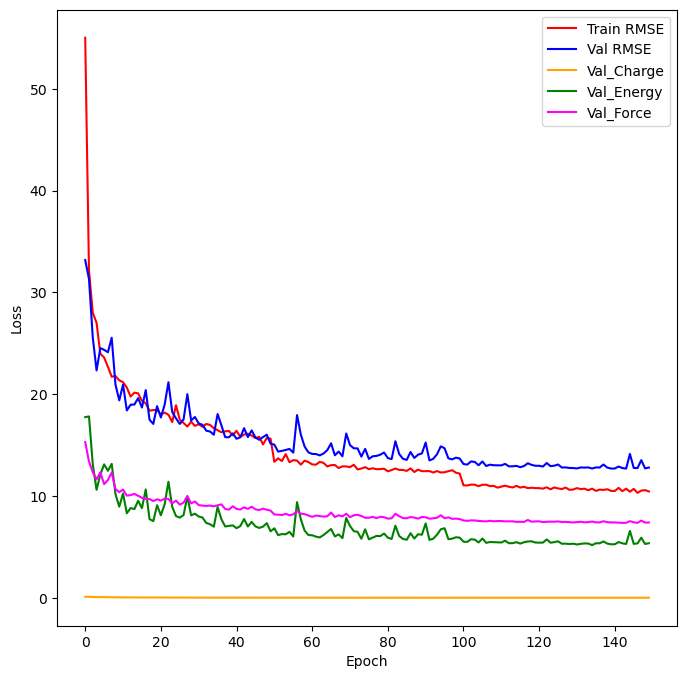

In [10]:
draw_loss_change(TOTAL_RMSE,TOTAL_VAL_RMSE,Val_RMSE_Charge,Val_RMSE_Energy,Val_RMSE_Force)


    # train_loss_list = [] #TOTAL
    # val_loss_list = [] #TOTAL
    
    # RMSE_Charge=[]
    # RMSE_Energy=[]
    # RMSE_Force=[]
    # TOTAL_RMSE=[]

In [15]:
draw_loss_change(train_acc_list, val_acc_list)

TypeError: draw_loss_change() missing 3 required positional arguments: 'charge', 'energy', and 'force'

In [22]:
#Reference total loss
charges_rmse= 0.037898898124694824
energy_rmse= 7.454645356858923
forces_rmse= 8.770966381430625

print(charges_rmse+energy_rmse+forces_rmse)

16.263510636414242
